In [1]:
import pandas as pd
import numpy as np
import pickle
import joblib
from stop_words import get_stop_words
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
pipeline = joblib.load('best_model.pkl')

In [3]:
pipeline.named_steps['clf'].feature_importances_

array([4.27127202e-06, 0.00000000e+00, 0.00000000e+00, ...,
       1.32200873e-06, 0.00000000e+00, 2.01016897e-06])

In [4]:
df = pd.read_csv('cleaned_data.csv',index_col=None)

In [5]:
df['label'] = df['label'].map({'FAKE':0, 'TRUE':1, np.nan: 2} )
df = df.dropna()

In [6]:
df['allwords'] = df['title']+" "+df['text']+" "+df['subject']
df_1 = df[['allwords','label']]

X = df_1['allwords']
y = df_1['label']
X_train, X_test, y_train,y_test= train_test_split(X, y, test_size=0.30,random_state=42,stratify=y)

In [7]:
a = pipeline.named_steps['vect'].get_feature_names()

In [8]:
imps = pipeline.named_steps['clf'].feature_importances_
fi = {'Importance':imps}

In [9]:
Importance = pd.DataFrame(fi,index=None).sort_values('Importance',ascending=False).head(25)

In [10]:
index = []
for i in Importance.index:
    term = a[i]
    index.append(term)

In [11]:
terms = pd.DataFrame({'Term': index, 'Position': Importance.index,'Importance': Importance.Importance})

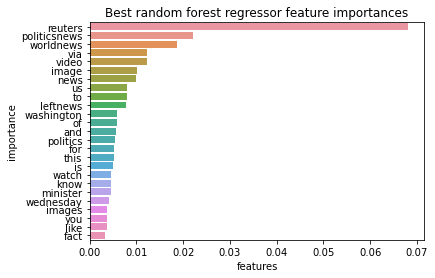

In [12]:
 _ = sns.barplot(y = 'Term', x='Importance',data=terms)
plt.xlabel('features')
plt.ylabel('importance')
plt.title('Best random forest regressor feature importances');

In [13]:
df.shape

(44267, 6)

In [14]:
df[df['label']==1]['subject'].unique()

array(['politicsnews', 'worldnews'], dtype=object)

In [15]:
df[df['label']==0]['subject'].unique()

array(['news', 'politics', 'government news', 'leftnews', 'usnews',
       'middleeast'], dtype=object)

In [16]:
true = df[df['label']==1]['allwords']

In [17]:
true.str.count('reuter').sum()

29112

In [18]:
fake = df[df['label']==0]['allwords']

In [19]:
fake.str.count('reuter').sum()

475

In [20]:
##reuters in true class 
29112/44267*100

65.76456502586578

In [21]:
##reuters in fake class 
475/44267*100

1.0730340885987304

In [22]:
true.str.count('politicsnews').sum()

11271

In [23]:
fake.str.count('politicsnews').sum()

0

In [24]:
true.str.count('leftnews').sum()

0

In [25]:
fake.str.count('leftnews').sum()

4309

In [27]:
df['text'].nunique()

38637

In [28]:
df['title'].nunique()

38234

From the analysis abpve it is clear that the word 'reuter' is causing the model to be leaky. This word appears only 1% of the time in fake news and 65% of the time in true news. This might help create a pattern which might not be always available or 'true' in a real world setting. Removing this word will help get better generalization.

   * Some of the headings of subject columns also appear in the top 25 feature importances. This is again misleading as both class of news does not come from the same subject. This can be another cause of leakage. 
   * Also, it will be better to apply stopwords removal one more time since we see terms like 'of' and 'and' being given top feature importances. 
   * We can also see that there are duplicate values in both text and title columns. If these classes are present in both test  and train sets than that will also yield to the leakiness. We plan to remove the repeated text and title from the dataset.